In [1]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch
import torchvision
from torchsummary import summary
import torchvision.models as models
import glob
from tqdm import tqdm
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# transforms for images
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomHorizontalFlip(p = 0.5)
])


# datasets
trainset = torchvision.datasets.ImageFolder("../input/fish-data/train", transform = transforms)
validset = torchvision.datasets.ImageFolder("../input/fish-data/val", transform = transforms)
testset = torchvision.datasets.ImageFolder("../input/fish-data/test", transform = transforms)

#batches
batch_size = 64

# loaders for data
trainloader = torch.utils.data.DataLoader(trainset , batch_size=batch_size , shuffle = True)
validloader = torch.utils.data.DataLoader(validset , batch_size=batch_size , shuffle = True)
testloader = torch.utils.data.DataLoader(testset  , batch_size=batch_size)

torch.Size([224, 224, 3])
tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.2039, 0.2196, 0.2235],
         [0.0000, 0.0000, 0.0000,  ..., 0.2000, 0.2078, 0.1961],
         [0.0000, 0.0000, 0.0000,  ..., 0.1922, 0.1961, 0.1686],
         ...,
         [0.3098, 0.2941, 0.3059,  ..., 0.0000, 0.0000, 0.0000],
         [0.3137, 0.3020, 0.3255,  ..., 0.0000, 0.0000, 0.0000],
         [0.3137, 0.2980, 0.3059,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.3333, 0.3333, 0.3216],
         [0.0000, 0.0000, 0.0000,  ..., 0.3294, 0.3216, 0.3098],
         [0.0000, 0.0000, 0.0000,  ..., 0.3216, 0.3255, 0.3176],
         ...,
         [0.3804, 0.3686, 0.3804,  ..., 0.0000, 0.0000, 0.0000],
         [0.3882, 0.3804, 0.4000,  ..., 0.0000, 0.0000, 0.0000],
         [0.3804, 0.3765, 0.3843,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.4392, 0.4431, 0.4431],
         [0.0000, 0.0000, 0.0000,  ..., 0.4549, 0.4549, 0.4431],
         [0.0000, 0.0000, 0.0000

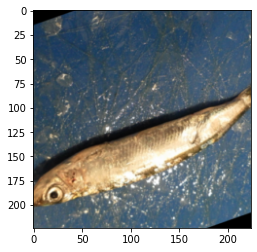

In [4]:
for img, label in testloader:
  print(np.transpose(img[0], (1,2,0)).shape)
  print(img[0])
  plt.imshow((img[0].detach().numpy().transpose(1, 2, 0)*255).astype(np.uint8))
  plt.show()
  break

In [5]:
len(testset)

1800

In [6]:
my_gpu = torch.cuda.is_available()
print(f'Train on gpu: {my_gpu}')
device = torch.device('cuda' if my_gpu else 'cpu')

Train on gpu: True


In [9]:
def copy_embeddings(m, i, o):
    """Copy embeddings from the penultimate layer.
    """
    o = o[:, :].detach().tolist()
    outputs.append(o)

In [23]:
from torchvision import models
import torch.nn.functional as F
import torch.nn as nn
# Use resnet-50 as a base model
class net(torch.nn.Module):
    def __init__(self, base_model, base_out_features, num_classes):
        super(net,self).__init__()
        self.base_model=base_model
        self.linear1 = torch.nn.Linear(base_out_features, 512)
        self.output = torch.nn.Linear(512,num_classes)
    def forward(self,x):
        x = F.relu(self.base_model(x))
        x = F.relu(self.linear1(x))
        x = self.output(x)
        return x

res = torchvision.models.resnet50(pretrained=False)

#for param in res.parameters():
#    param.requires_grad=False

model = net(base_model=res, base_out_features=res.fc.out_features, num_classes=9)
model = model.to(device)

In [24]:
model=torch.load('/kaggle/input/all-scratch-models/all_pb_scratch_models_AI_vishvesh/resnet50_fish.pb')

In [25]:
model.eval()

net(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [26]:
# Select the desired layer
layer = model._modules.get('linear1')
# attach hook to the penulimate layer
_ = layer.register_forward_hook(copy_embeddings)

In [27]:
outputs = []  # list of embeddings
#inputs, labels = inputs.to(device), labels.to(device)
# Generate image's embeddings for all images in trainloader and saves them in the list outputs
for X, y in testloader:
    X=X.to(device)
    y=y.to(device)
    _ = model(X)

In [28]:
# flatten list of embeddings to remove batches
list_embeddings = [item for sublist in outputs for item in sublist]
print(len(list_embeddings))

1800


In [29]:
print(list_embeddings[0])

[-11.03221321105957, -4.6968584060668945, -7.622925758361816, -4.982893943786621, -3.924480438232422, -1.6519455909729004, -4.525319576263428, -7.194790840148926, -8.511663436889648, -2.2654576301574707, -7.485374450683594, -2.534792423248291, -7.45335054397583, 13.226746559143066, -10.487442970275879, -11.685802459716797, -4.3078718185424805, -5.150002479553223, -8.55051326751709, -20.477630615234375, -4.14874267578125, -4.188809871673584, 3.9935362339019775, -10.81163215637207, -5.949720859527588, -6.99660062789917, -8.402979850769043, -10.996711730957031, -4.316126823425293, -6.058478832244873, 10.632745742797852, -7.807940483093262, 1.9049303531646729, 14.013054847717285, -6.922725677490234, -0.4586442708969116, -5.113711833953857, -5.276111125946045, -11.291038513183594, -3.6467034816741943, -7.946982383728027, 0.33819931745529175, -6.9954681396484375, -2.1287031173706055, -3.0434913635253906, -11.865032196044922, -4.617303848266602, -17.913379669189453, -9.15147590637207, 4.42608

In [30]:
from sklearn.manifold import TSNE
from matplotlib import cm, colors
def tsne_plot(list_embeddings):
    "Creates and TSNE model and plots it"
    classes_name = ['Black Sea Sprat', 'Gilt-Head Bream', 'Hourse Mackerel', 'Red Mullet', 
                    'Red Sea Bream', 'Sea Bass', 'Shrimp', 'Striped Red Mullet', 'Trout']
    labels=[]
    tokens = []
    num_name=[]
    i=0
    for word in list_embeddings:
        tokens.append(word)
        if i<200:
            labels.append('Black Sea Sprat')
            num_name.append(1)
        elif i<400:
            labels.append('Gilt-Head Bream')
            num_name.append(2)
        elif i<600:
            labels.append('Hourse Mackerel')
            num_name.append(3)
        elif i<800:
            labels.append('Red Mullet')
            num_name.append(4)
        elif i<1000:
            labels.append('Red Sea Bream')
            num_name.append(5)
        elif i<1200:
            labels.append('Sea Bass')
            num_name.append(6)
        elif i<1400:
            labels.append('Shrimp')
            num_name.append(7)
        elif i<1600:
            labels.append('Striped Red Mullet')
            num_name.append(8)
        else:
            labels.append('Trout')
            num_name.append(9)
        i=i+1
            
        
        #labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        if i<200:
            plt.scatter(x[i],y[i],c='red')            
        elif i<400:
            plt.scatter(x[i],y[i],c='green')            
        elif i<600:
            plt.scatter(x[i],y[i],c='blue')            
        elif i<800:
            plt.scatter(x[i],y[i],c='pink')            
        elif i<1000:
            plt.scatter(x[i],y[i],c='orange')            
        elif i<1200:
            plt.scatter(x[i],y[i],c='yellow')            
        elif i<1400:
            plt.scatter(x[i],y[i],c='black')            
        elif i<1600:
            plt.scatter(x[i],y[i],c='cyan')            
        else:
            plt.scatter(x[i],y[i],c='magenta')            
        
        plt.annotate(num_name[i],xy=(x[i], y[i]),xytext=(x[i],2),textcoords='offset points',ha='right',va='bottom')
    
    plt.show()

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


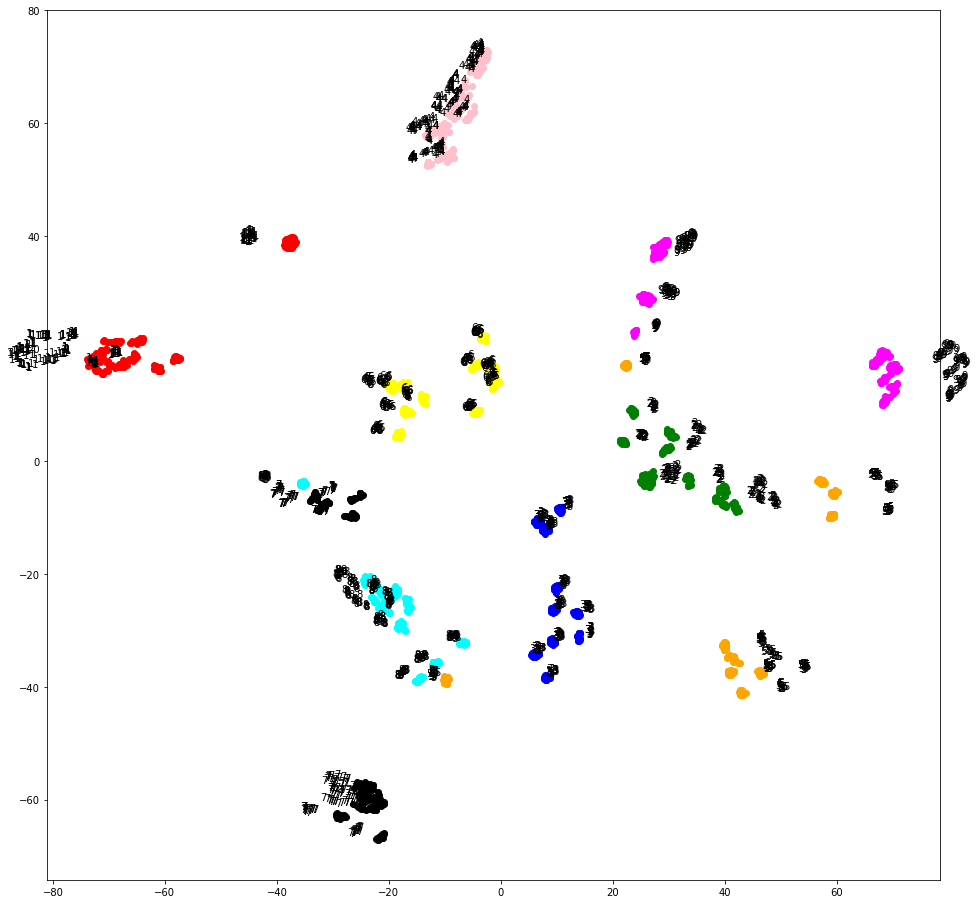

In [31]:

tsne_plot(flat_list)